# Build Model For Sentiment Analysis

### Load Twitter Data (from -2017-2022)

In [1]:
import pandas as pd
twitter_data =  pd.read_csv('./data/twitter-data.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
# twitter_data['date'] = twitter_data['date'].str.replace('PDT', ' ', regex=True)
# twitter_data.date = pd.to_datetime(twitter_data.date).dt.strftime('%Y-%m-%d')
# twitter_data = twitter_data.set_index('date')
print(twitter_data.shape)
twitter_data.head()


(1600000, 6)


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_data.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


### Select two columns text and target and split text and train data

In [2]:
from sklearn.model_selection import train_test_split

selected_twitter_data = twitter_data[['target', 'text']]
X = selected_twitter_data["text"]
y = selected_twitter_data["target"]
y = y.replace(4,1)# in twitter 4 is for positive and 0 is negative sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Tokenize and create token sequences 

In [3]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


# Define parameters for the module
vocab_size = 20000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# create token sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


2023-04-19 23:55:46.236704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 23:55:46.451381: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-19 23:55:46.490487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-19 23:55:46.490519: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

### Create  Model For Sentiment Analysis using twitter data

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout,LSTM,Bidirectional
num_epochs = 5

# Define a sequential model 
twitter_model = Sequential([
    
# Add an embedding layer that converts input integers to dense vectors of fixed size
Embedding(vocab_size, embedding_dim, input_length=max_length),
    
# Add a bidirectional LSTM layer with 64 units, which processes the input sequence in both directions
# and returns a sequence of output values for each input time step
Bidirectional(LSTM(64, return_sequences=True)),
    
# Add another bidirectional LSTM layer with 32 units, which processes the output sequence of the first LSTM layer
# and returns a single output value for the entire sequence
Bidirectional(LSTM(32)),
    
# Add a fully connected dense layer with 64 units and a ReLU activation function
Dense(64, activation='relu'),
    
# Add a dropout layer to randomly drop out 50% of the input units during training, to prevent overfitting
Dropout(0.5),
    
# Add a final fully connected dense layer with a single output unit and a sigmoid activation function,
# which outputs a probability between 0 and 1 of the input sequence belonging to a particular class
Dense(1, activation='sigmoid')
])
twitter_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

twitter_model.summary()
twitter_model.fit(X_train_padded, y_train, epochs=num_epochs,batch_size=64, validation_data=(X_test_padded, y_test))
twitter_model.save('./data/sentiment-analysis-model')
# Evaluate the model
test_loss, test_acc = twitter_model.evaluate(X_test_padded, y_test, verbose=2)
print("Test Accuracy: ", test_acc)


2023-04-15 18:42:14.526849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 18:42:14.527075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-15 18:42:14.527139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-15 18:42:14.527182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-15 18:42:14.527220: W tensorflow/c

Epoch 1/5
20000/20000 [==============================] - 1635s 82ms/step - loss: 0.4167 - accuracy: 0.8103 - val_loss: 0.3859 - val_accuracy: 0.8246
Epoch 2/5
20000/20000 [==============================] - 1654s 83ms/step - loss: 0.3735 - accuracy: 0.8343 - val_loss: 0.3737 - val_accuracy: 0.8316
Epoch 3/5
20000/20000 [==============================] - 1703s 85ms/step - loss: 0.3522 - accuracy: 0.8456 - val_loss: 0.3761 - val_accuracy: 0.8323
Epoch 4/5
20000/20000 [==============================] - 1923s 96ms/step - loss: 0.3339 - accuracy: 0.8549 - val_loss: 0.3753 - val_accuracy: 0.8327
Epoch 5/5
20000/20000 [==============================] - 2023s 101ms/step - loss: 0.3166 - accuracy: 0.8637 - val_loss: 0.3826 - val_accuracy: 0.8312


INFO:tensorflow:Assets written to: ./data/sentiment-analysis-model/assets


INFO:tensorflow:Assets written to: ./data/sentiment-analysis-model/assets


10000/10000 - 253s - loss: 0.3826 - accuracy: 0.8312 - 253s/epoch - 25ms/step
Test Accuracy:  0.8312031030654907


### Analyse the Model

10000/10000 - 167s - loss: 0.4199 - accuracy: 0.8064 - 167s/epoch - 17ms/step
Test Accuracy:  0.8063781261444092
1/1 [==============================] - 1s 628ms/step
[[0.92664796]]
1/1 [==============================] - 0s 19ms/step
[[0.03033858]]


### Test will text input

In [ ]:
# Test with input entry
entry = ['I am happy']
test_text = tokenizer.texts_to_sequences(entry)
test_text_padded = pad_sequences(test_text, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = twitter_model.predict(test_text_padded)
#0 : bad
#1 : good
print(prediction)

entry = ['Our economy is in very bad condition']
test_text = tokenizer.texts_to_sequences(entry)
test_text_padded = pad_sequences(test_text, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = twitter_model.predict(test_text_padded)
#0 : bad
#1 : good
print(prediction)

1/1 [==============================] - 0s 102ms/step
[[0.9495871]]
1/1 [==============================] - 0s 22ms/step
[[0.03625218]]


## Import NEPSE Combined data (includes Inflation Rate, Interest Rate, Liquidity)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To avoid FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
nepse_combined_data = pd.read_csv('/var/www/data-mining/data-science-class/data/combined-nepse.csv')
nepse_combined_data.head()


,Date,index_id,open,high,low,close_index,per_change,change_,turnover,DT_Row_Index,BaseInterestRate,InflationRate,Balance
0,2017-07-16,12,1582.67,1584.38,1580.08,1583.57,0.06,0.90,4.307240e+08,1309,5.75,3.4,5.422000e+10
1,2017-07-17,12,1583.57,1604.31,1582.48,1604.15,1.30,20.58,5.992900e+08,1308,5.75,3.4,5.422000e+10
2,2017-07-18,12,1604.15,1638.41,1603.76,1638.41,2.14,34.26,1.102710e+09,1307,5.75,3.4,5.422000e+10
3,2017-07-19,12,1638.41,1652.73,1634.97,1637.27,-0.07,-1.14,1.107470e+09,1306,5.75,3.4,5.422000e+10
4,2017-07-20,12,1637.27,1640.34,1633.60,1635.75,-0.09,-1.52,9.079460e+08,1305,5.75,3.4,5.422000e+10


### Add Twitter Sentiment Score to NEPSE dataset (We don't have current dataset so lets add all positive for now)

In [ ]:
import datetime
# date_wise_sentiment_score = []

# for index,row in nepse_combined_data.iterrows():
#     tweets_of_the_day = (tweets_from_2016.loc[tweets_from_2016.index==index]).groupby('date')['target'].mean()
#     print(tweets_of_the_day)
#     break


### Feature Selection and Scaling

In [21]:

# only select the required columns
FEATURES = ['close_index','turnover','BaseInterestRate','InflationRate','Balance','change_','open','Date']
data_filtered = nepse_combined_data[FEATURES]
# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['SentimentScore'] = 0.7
def feature_selection(df):

    df['turnover'] = df['turnover'] / 1000000
    df['Balance'] = df['Balance']/1000000
    #  add  trend
    df['Trend']  = 0 # 0='Neutral',1=Positive,2=Negative
    # add future trend
    df['FutureTrend'] =0

    for index,row in df.iterrows():
        trend_value = row['close_index']- row['open']
        df.loc[index,'Trend'] = 1 if trend_value>0 else (0 if trend_value==0 else 2)
        next_10_days_index = index+10
        if next_10_days_index not in df.index:
            next_10_days_index = np.max(df.index)
        nextn_days_df = df.loc[next_10_days_index]
        trend_value_ndays = row['close_index']- nextn_days_df['close_index']
        df.loc[index,'FutureTrend'] = 1 if trend_value_ndays>0 else (0 if trend_value_ndays==0 else 2)
    # make date as index
  
    return df

data_filtered_ext= feature_selection(data_filtered_ext)
data_filtered_ext['Date'] = pd.to_datetime(data_filtered_ext['Date'], errors='coerce')
data_filtered_ext.index = pd.to_datetime(data_filtered_ext['Date'],format='%y-%m-%d')
data_filtered_ext = data_filtered_ext.sort_index(ascending=True)
data_filtered_ext = data_filtered_ext.drop('Date',axis=1)
data_filtered_ext.head()

,close_index,turnover,BaseInterestRate,InflationRate,Balance,change_,open,SentimentScore,Trend,FutureTrend
Date,,,,,,,,,,
2017-07-16,1583.57,430.724000,5.75,3.4,54219.996176,0.90,1582.67,0.7,1,2
2017-07-17,1604.15,599.289984,5.75,3.4,54219.996176,20.58,1583.57,0.7,1,2
2017-07-18,1638.41,1102.710016,5.75,3.4,54219.996176,34.26,1604.15,0.7,1,2
2017-07-19,1637.27,1107.469952,5.75,3.4,54219.996176,-1.14,1638.41,0.7,2,2
2017-07-20,1635.75,907.945984,5.75,3.4,54219.996176,-1.52,1637.27,0.7,2,2


### Scaling the Multivariate Input Data

In [39]:
# Get the number of rows in the data
from sklearn.preprocessing import MinMaxScaler


nrows = data_filtered_ext.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered_ext)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['close_index'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(1304, 10)


### Transforming the Multivariate Data

In [40]:
# Set the sequence length - this is the timeframe used to make a single prediction
import math
sequence_length = 10
# Prediction Index
index_Close = data_filtered.columns.get_loc("close_index")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1034, 10, 10) (1034,)
(260, 10, 10) (260,)
0.25867246260760146
0.25867246260760146


### Train the Multivariate Prediction Model

In [41]:
# Configure the neural network model
from keras import Sequential 
from keras.layers import LSTM, Dense, Dropout,Bidirectional 
from keras.callbacks import EarlyStopping


nepse_predict_model = Sequential()
# nepse_predict_model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons)
print(n_neurons, x_train.shape[1], x_train.shape[2])
nepse_predict_model.add(Bidirectional(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))) 
nepse_predict_model.add(Bidirectional(LSTM(n_neurons, return_sequences=False)))
nepse_predict_model.add(Dense(5))
nepse_predict_model.add(Dense(1))

# Compile the nepse_predict_model
nepse_predict_model.compile(optimizer='adam', loss='mse')

# Training the nepse_predict_model
epochs = 20
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
history = nepse_predict_model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                     callbacks=[early_stop]
                   )

100
100 10 10
Epoch 1/20
65/65 [==============================] - 5s 22ms/step - loss: 0.0087 - val_loss: 6.7307e-04
Epoch 2/20
65/65 [==============================] - 1s 13ms/step - loss: 3.6837e-04 - val_loss: 5.7185e-04
Epoch 3/20
65/65 [==============================] - 1s 13ms/step - loss: 2.8833e-04 - val_loss: 4.1030e-04
Epoch 4/20
65/65 [==============================] - 1s 14ms/step - loss: 2.5458e-04 - val_loss: 4.1402e-04
Epoch 5/20
65/65 [==============================] - 1s 16ms/step - loss: 4.4685e-04 - val_loss: 0.0012
Epoch 6/20
65/65 [==============================] - 1s 14ms/step - loss: 2.5441e-04 - val_loss: 7.9276e-04
Epoch 7/20
65/65 [==============================] - 1s 14ms/step - loss: 2.5869e-04 - val_loss: 3.6795e-04
Epoch 8/20
65/65 [==============================] - 1s 11ms/step - loss: 4.0627e-04 - val_loss: 7.0235e-04
Epoch 9/20
65/65 [==============================] - 1s 9ms/step - loss: 2.2502e-04 - val_loss: 4.0433e-04
Epoch 10/20
65/65 [=============

#### Plot the loss curve

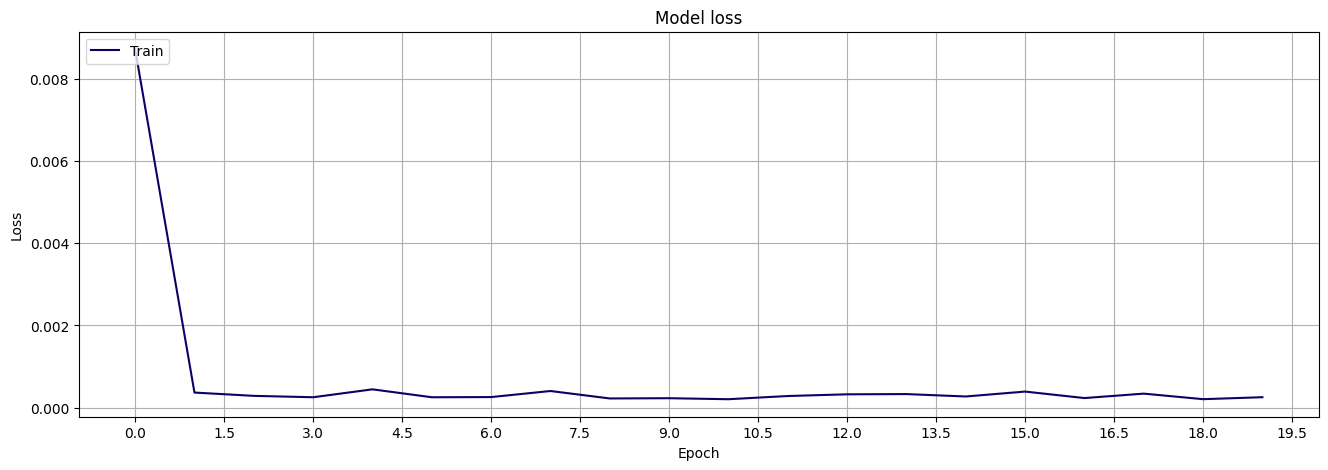

In [42]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Evaluate Model Performance

In [43]:
results = nepse_predict_model.evaluate(x_test, y_test, batch_size=128,return_dict=True)
print(results)
history.history


3/3 [==============================] - 0s 9ms/step - loss: 3.3731e-04
{'loss': 0.00033730597351677716}


{'loss': [0.008718336001038551,
  0.0003683651448227465,
  0.00028832725365646183,
  0.00025458025629632175,
  0.00044685223838314414,
  0.00025440636090934277,
  0.00025868721422739327,
  0.00040626624831929803,
  0.0002250216930406168,
  0.0002310350100742653,
  0.00020648687495850027,
  0.0002844634000211954,
  0.000325692817568779,
  0.0003314295317977667,
  0.0002731758286245167,
  0.00039240127080120146,
  0.00023469659208785743,
  0.00034235743805766106,
  0.00020748387032654136,
  0.0002555720857344568],
 'val_loss': [0.000673071073833853,
  0.0005718477186746895,
  0.0004103009996470064,
  0.000414018431911245,
  0.0012227700790390372,
  0.0007927618571557105,
  0.00036795332562178373,
  0.0007023518555797637,
  0.0004043261578772217,
  0.0005766268586739898,
  0.0008302684873342514,
  0.0002566706098150462,
  0.0004909445997327566,
  0.00045839918311685324,
  0.002688374137505889,
  0.00024914045934565365,
  0.0004800272872671485,
  0.0023649747017771006,
  0.0013342141173779

In [44]:
# Get the predicted values
from sklearn.metrics import mean_absolute_error


y_pred_scaled = nepse_predict_model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

9/9 [==============================] - 1s 4ms/step
Median Absolute Error (MAE): 30.09
Mean Absolute Percentage Error (MAPE): 1.4 %
Median Absolute Percentage Error (MDAPE): 1.21 %


#### Create Graph and compare the forecast with actual Values

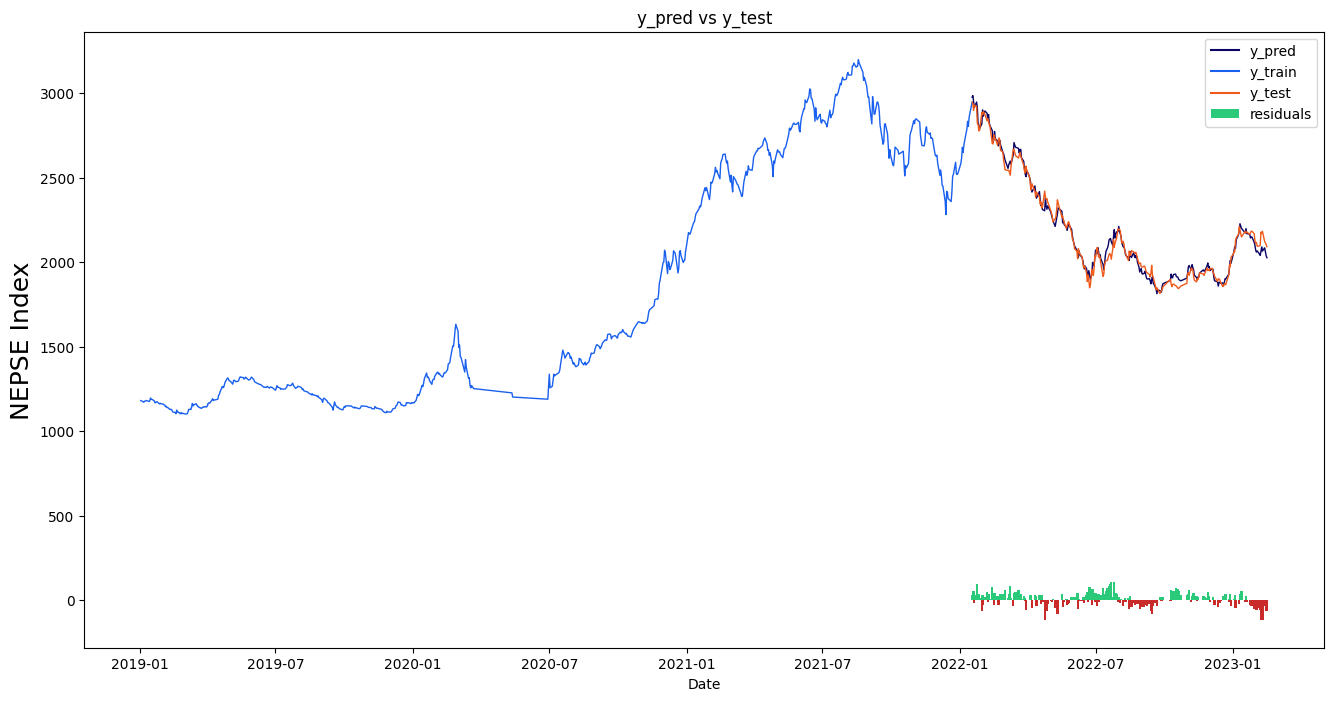

In [45]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['close_index'][:train_data_len + 1]).rename(columns={'close_index': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['close_index'][train_data_len:]).rename(columns={'close_index': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('NEPSE Index', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

### Predict for Next Day's Index

In [30]:
df_temp = nepse_combined_data[-sequence_length:]
df_temp = df_temp.sort_index(ascending=True)
df_temp = df_temp.drop('Date',axis=1)
new_df = df_temp.filter(FEATURES)
N = sequence_length
end_date = '2023-02-15' 
# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_index_scaled = nepse_predict_model.predict(np.array(X_test_new))
pred_index_unscaled = scaler_pred.inverse_transform(pred_index_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
index_today = 2090.49
predicted_index = np.round(pred_index_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (index_today * 100)/predicted_index, 2)

plus = '+'; minus = ''
print(f'Actual close index for NEPSE Index at {end_date} is {index_today}')
print(f'The predicted close index is {predicted_index} ({plus if change_percent > 0 else minus}{change_percent}%)')
df_temp.tail()

ValueError: X has 7 features, but MinMaxScaler is expecting 10 features as input.